In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

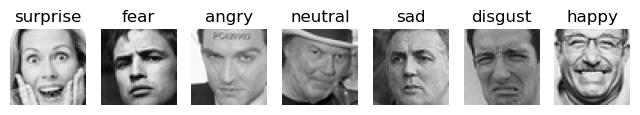

In [3]:
i = 1
plt.figure(figsize=(8, 8))
for expression in os.listdir('/kaggle/input/face-expression-recognition-dataset/images/validation/'):
    img = load_img(('/kaggle/input/face-expression-recognition-dataset/images/validation/' + expression + '/' +
                    os.listdir('/kaggle/input/face-expression-recognition-dataset/images/validation/' + expression)[0]))
    plt.subplot(1, 7, i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1

plt.show()

# Check the amount of data in each folder in training dataset

In [4]:
for expression in os.listdir('/kaggle/input/face-expression-recognition-dataset/images/train/'):
    print(expression, "folder contains\t\t",
          len(os.listdir('/kaggle/input/face-expression-recognition-dataset/images/train/' + expression)), "images")

surprise folder contains		 3205 images
fear folder contains		 4103 images
angry folder contains		 3993 images
neutral folder contains		 4982 images
sad folder contains		 4938 images
disgust folder contains		 436 images
happy folder contains		 7164 images


# Check the amount of data in each folder in testing dataset

In [5]:
for expression in os.listdir('/kaggle/input/face-expression-recognition-dataset/images/validation/'):
    print(expression, "folder contains\t\t",
          len(os.listdir('/kaggle/input/face-expression-recognition-dataset/images/validation/' + expression)), "images")

surprise folder contains		 797 images
fear folder contains		 1018 images
angry folder contains		 960 images
neutral folder contains		 1216 images
sad folder contains		 1139 images
disgust folder contains		 111 images
happy folder contains		 1825 images


In [6]:
model = tf.keras.models.Sequential(
    [
        Conv2D(64,(3,3),padding='same',activation='relu',input_shape=(48,48,1)),
        MaxPooling2D((2,2)),
        Conv2D(128,(3,3),padding='same',activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(256,(3,3),padding='same',activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(512,(3,3),padding='same',activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512,activation='relu'),
        Dropout(0.5),
        Dense(7,activation='softmax')
    ]
)

model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 256)        0

# Data Augmentation

In [7]:
datagen_train = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.3,
    horizontal_flip=True
)

train_generator = datagen_train.flow_from_directory(
    '/kaggle/input/face-expression-recognition-dataset/images/train/',
    batch_size=64,
    target_size=(48, 48),
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical'
)

datagen_test = ImageDataGenerator(
    rescale=1. / 255,
    zoom_range=0.3,
    horizontal_flip=True
)

test_generator = datagen_test.flow_from_directory(
    '/kaggle/input/face-expression-recognition-dataset/images/validation/',
    batch_size=64,
    target_size=(48, 48),
    shuffle=True,
    color_mode='grayscale',
    class_mode='categorical'
)

steps_per_epoch = train_generator.n / train_generator.batch_size
testing_steps = test_generator.n / test_generator.batch_size

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [8]:
history = model.fit(
    x=train_generator,
    epochs=100,
    validation_data=test_generator
)

Epoch 1/100
451/451 [==============================] - 185s 383ms/step - loss: 1.8079 - accuracy: 0.2490 - val_loss: 1.7735 - val_accuracy: 0.2659
Epoch 2/100
451/451 [==============================] - 50s 112ms/step - loss: 1.7111 - accuracy: 0.3077 - val_loss: 1.6158 - val_accuracy: 0.3656
Epoch 3/100
451/451 [==============================] - 51s 113ms/step - loss: 1.5535 - accuracy: 0.3933 - val_loss: 1.4798 - val_accuracy: 0.4280
Epoch 4/100
451/451 [==============================] - 52s 116ms/step - loss: 1.4452 - accuracy: 0.4416 - val_loss: 1.3637 - val_accuracy: 0.4809
Epoch 5/100
451/451 [==============================] - 50s 111ms/step - loss: 1.3783 - accuracy: 0.4685 - val_loss: 1.3430 - val_accuracy: 0.4827
Epoch 6/100
451/451 [==============================] - 50s 112ms/step - loss: 1.3263 - accuracy: 0.4935 - val_loss: 1.2783 - val_accuracy: 0.5137
Epoch 7/100
451/451 [==============================] - 50s 110ms/step - loss: 1.2854 - accuracy: 0.5120 - val_loss: 1.2776 

# Plot the training and validation accuracy and loss at each epoch

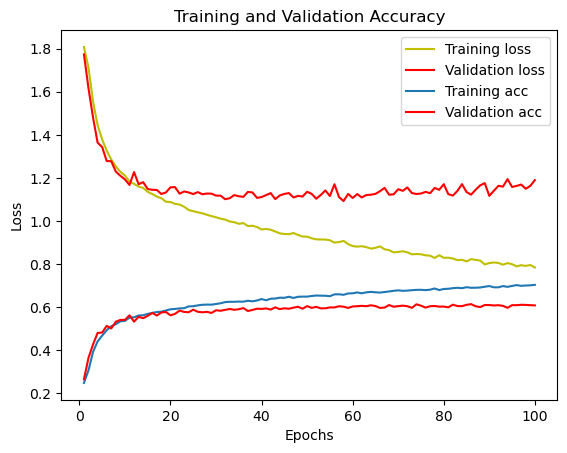

In [9]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
plt.plot(epochs,acc,label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()